In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [ ]:
import torch
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import wavefront as w
from svetlanna.units import ureg

import analytical_solutions as anso

# Propagation through the square aperture

In this example we will use rectangular aperture from `svetlanna.elements` to solve the diffraction problem. 

## Creating numerical mesh with using `SimulationParameters` class

In [220]:
# screen size
lx = 4 * ureg.mm
ly = 4 * ureg.mm

# distance between the screen and the aperture, mm
z = 220 * ureg.mm

# size of the aperture, mm
a = 1 * ureg.mm

# wavelength, mm
wavelength = 1064 * ureg.nm

# number of nodes
Nx = 2048
Ny = 2048

# creating SimulationParameters exemplar
sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [221]:
# return 2d-tensors of x and y coordinates
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Creating a plane wave using `svetlanna.wavefront.plane_wave`

Let's create a plane wave that will fall on the aperture:

In [222]:
# create plane wave
incident_field = w.Wavefront.plane_wave(
    simulation_parameters=sim_params,
    distance=0 * ureg.cm,
    wave_direction=[0, 0, 1]
)

## Creating a square aperture using `svetlanna.elements.RectangularAperture`

In [223]:
square_aperture = elements.RectangularAperture(
    simulation_parameters=sim_params,
    height=a,
    width=a,
)

Let's see the shape of the aperture using `.get_transmission_function()` class method:

In [224]:
aperture_transmission_function = square_aperture.get_transmission_function()

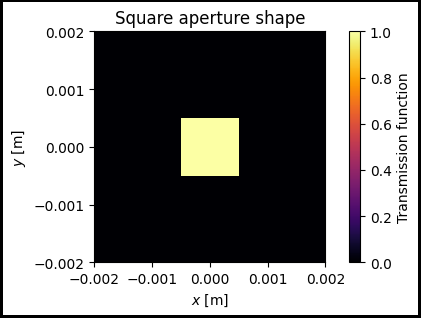

In [225]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, aperture_transmission_function, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Square aperture shape')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Transmission function')

## Intensity profile on the screen after propagation through the square aperture

In this section we will solve the direct problem of diffraction on a square aperture using Angular Spectrum method from `FreeSpace` class

In [226]:
field_after_aperture = square_aperture.forward(
    incident_wavefront=incident_field
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=z,
    method="AS"
)

output_wavefront = free_space.forward(
    incident_wavefront=field_after_aperture
)

output_intensity = output_wavefront.intensity

Visualize the intensity distribution:

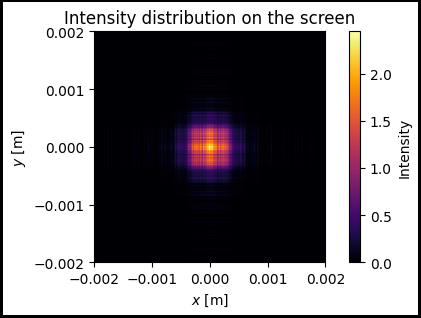

In [227]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, output_intensity, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity distribution on the screen')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Intensity')

## Comparing with analytical solution

In this section we wll compare our numeric solution which was calculated using Angular Spectrum method with analytical solution of the problem that expressed in terms of Fresnel's integrals

In [228]:
rect_int = anso.SquareFresnel(
    distance=z,
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    square_size=a,
    wavelength=wavelength
)

intensity_analytic = rect_int.intensity()

Let's visualize both intensity distributions:

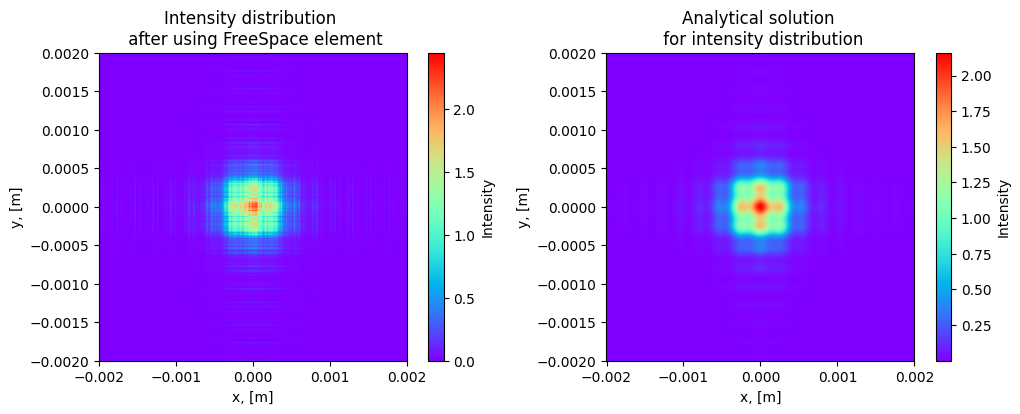

In [229]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
beam1 = ax[0].pcolormesh(x_grid, y_grid, output_intensity, cmap='rainbow')
beam2 = ax[1].pcolormesh(x_grid, y_grid, intensity_analytic, cmap='rainbow')

ax[0].set_title('Intensity distribution \n after using FreeSpace element')
ax[1].set_title('Analytical solution \n for intensity distribution')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_xlabel('x, [m]')
ax[0].set_ylabel('y, [m]')
ax[1].set_xlabel('x, [m]')
ax[1].set_ylabel('y, [m]')
fig.colorbar(beam1, ax=ax[0], label='Intensity')
fig.colorbar(beam2, ax=ax[1], label='Intensity')